**Configuration**

In [1]:
CFG = {'TPU': 0,
       'block_size': 12096, 
       'block_stride': 12096//16,
       'patch_size': 14, 
       
       'fog_model_dim': 320,
       'fog_model_num_heads': 6,
       'fog_model_num_encoder_layers': 5,
       'fog_model_num_lstm_layers': 2,
       'fog_model_first_dropout': 0.1,
       'fog_model_encoder_dropout': 0.1,
       'fog_model_mha_dropout': 0.0,
      }

assert CFG['block_size'] % CFG['patch_size'] == 0
assert CFG['block_size'] % CFG['block_stride'] == 0

'''
Mean-std normalization function. 
Example input: shape (5000), dtype np.float32
Example output: shape (5000), dtype np.float32

Used to normalize AccV, AccML, AccAP values.

'''

def sample_normalize(sample):
    mean = tf.math.reduce_mean(sample)
    std = tf.math.reduce_std(sample)
    sample = tf.math.divide_no_nan(sample-mean, std)
    
    return sample.numpy()

'''
Function for splitting a series into blocks. Blocks can overlap. 
How the function works:
Suppose we have a series with AccV, AccML, AccAP columns and len of 50000, that is (50000, 3). 
First, the series is padded so that the final length is divisible by CFG['block_size'] = 15552. Now the series shape is (62208, 3).
Then we get blocks: first block is series[0:15552, :], second block is series[972:16524, :], ... , last block is series[46656:62208, :].

'''

def get_blocks(series, columns):
    series = series.copy()
    series = series[columns]
    series = series.values
    series = series.astype(np.float32)
    
    block_count = math.ceil(len(series) / CFG['block_size'])
    
    series = np.pad(series, pad_width=[[0, block_count*CFG['block_size']-len(series)], [0, 0]])
    
    block_begins = list(range(0, len(series), CFG['block_stride']))
    block_begins = [x for x in block_begins if x+CFG['block_size'] <= len(series)]
    
    blocks = []
    for begin in block_begins:
        values = series[begin:begin+CFG['block_size']]
        blocks.append({'begin': begin,
                       'end': begin+CFG['block_size'],
                       'values': values})
    
    return blocks

'''
Train and inference batch size

'''

GPU_BATCH_SIZE = 16

**Imports and Utils**

In [2]:
import os
import math
import random
import warnings
import numpy as np 
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy

from tqdm import tqdm
from itertools import cycle
from joblib import Parallel, delayed
from sklearn.metrics import average_precision_score

warnings.filterwarnings("ignore")
pd.set_option('display.max_colwidth', None)

def folder(path): 
    if not os.path.exists(path): os.makedirs(path)
        
def plot(e, size=(20, 4)):
    plt.figure(figsize=size)
    plt.plot(e)
    plt.show()

**Model**

In [3]:
'''
The transformer encoder layer
For more details, see https://arxiv.org/pdf/1706.03762.pdf [Attention Is All You Need]

'''

class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self):
        super().__init__()
        
        self.mha = tf.keras.layers.MultiHeadAttention(num_heads=CFG['fog_model_num_heads'], key_dim=CFG['fog_model_dim'], dropout=CFG['fog_model_mha_dropout'])
        
        self.add = tf.keras.layers.Add()
        
        self.layernorm = tf.keras.layers.LayerNormalization()
        
        self.seq = tf.keras.Sequential([tf.keras.layers.Dense(CFG['fog_model_dim'], activation='relu'), 
                                        tf.keras.layers.Dropout(CFG['fog_model_encoder_dropout']), 
                                        tf.keras.layers.Dense(CFG['fog_model_dim']), 
                                        tf.keras.layers.Dropout(CFG['fog_model_encoder_dropout']),
                                       ])
        
    def call(self, x):
        attn_output = self.mha(query=x, key=x, value=x)
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        x = self.add([x, self.seq(x)])
        x = self.layernorm(x)
        
        return x
    
'''
FOGEncoder is a combination of transformer encoder (D=320, H=6, L=5) and two BidirectionalLSTM layers

'''

class FOGEncoder(tf.keras.Model):
    def __init__(self):
        super().__init__()
        
        self.first_linear = tf.keras.layers.Dense(CFG['fog_model_dim'])
        
        self.add = tf.keras.layers.Add()
        
        self.first_dropout = tf.keras.layers.Dropout(CFG['fog_model_first_dropout'])
        
        self.enc_layers = [EncoderLayer() for _ in range(CFG['fog_model_num_encoder_layers'])]
        
        self.lstm_layers = [tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(CFG['fog_model_dim'], return_sequences=True)) for _ in range(CFG['fog_model_num_lstm_layers'])]
        
        self.sequence_len = CFG['block_size'] // CFG['patch_size']
        self.pos_encoding = tf.Variable(initial_value=tf.random.normal(shape=(1, self.sequence_len, CFG['fog_model_dim']), stddev=0.02), trainable=True)
        
    def call(self, x, training=None): # (GPU_BATCH_SIZE, CFG['block_size'] // CFG['patch_size'], CFG['patch_size']*3), Example shape (4, 864, 42)
        x = x / 50.0 # Normalization attempt in the segment [-1, 1]
        x = self.first_linear(x) # (GPU_BATCH_SIZE, CFG['block_size'] // CFG['patch_size'], CFG['fog_model_dim']), Example shape (4, 864, 320)
          
        if training: # augmentation by randomly roll of the position encoding tensor
            random_pos_encoding = tf.roll(tf.tile(self.pos_encoding, multiples=[GPU_BATCH_SIZE, 1, 1]), 
                                          shift=tf.random.uniform(shape=(GPU_BATCH_SIZE,), minval=-self.sequence_len, maxval=0, dtype=tf.int32),
                                          axis=GPU_BATCH_SIZE * [1],
                                          )
            x = self.add([x, random_pos_encoding])
        
        else: # without augmentation 
            x = self.add([x, tf.tile(self.pos_encoding, multiples=[GPU_BATCH_SIZE, 1, 1])])
            
        x = self.first_dropout(x)
        
        for i in range(CFG['fog_model_num_encoder_layers']): x = self.enc_layers[i](x) # (GPU_BATCH_SIZE, CFG['block_size'] // CFG['patch_size'], CFG['fog_model_dim']), Example shape (4, 864, 320)
        for i in range(CFG['fog_model_num_lstm_layers']): x = self.lstm_layers[i](x) # (GPU_BATCH_SIZE, CFG['block_size'] // CFG['patch_size'], CFG['fog_model_dim']*2), Example shape (4, 864, 640)
            
        return x
    
class FOGModel(tf.keras.Model):
    def __init__(self):
        super().__init__()
        
        self.encoder = FOGEncoder()
        self.last_linear = tf.keras.layers.Dense(4) 
        
    def call(self, x): # (GPU_BATCH_SIZE, CFG['block_size'] // CFG['patch_size'], CFG['patch_size']*3), Example shape (4, 864, 42)
        x = self.encoder(x) # (GPU_BATCH_SIZE, CFG['block_size'] // CFG['patch_size'], CFG['fog_model_dim']*2), Example shape (4, 864, 640)
        x = self.last_linear(x) # (GPU_BATCH_SIZE, CFG['block_size'] // CFG['patch_size'], 3), Example shape (4, 864, 4)
        x = tf.nn.sigmoid(x) # Sigmoid activation
        
        return x

**Train Defog Data - Preparing**

In [4]:
'''
Create defog and notype train blocks with 
AccV, AccML, AccAP, StartHesitation, Turn, Walking, Event, StartHesitation_mask, Turn_mask, Walking_mask, Event_mask columns 

'''

save_path = '/kaggle/working/train/defog'; folder(save_path); 
defog_metadata = pd.read_csv('/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/defog_metadata.csv').set_index('Id')

def get_blocks_descriptions(Id):
    blocks_descriptions = []
    
    try: 
        series = pd.read_csv(f'/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/train/defog/{Id}.csv')
        series['Event'] = series[['StartHesitation', 'Turn', 'Walking']].aggregate('max', axis=1)
        
        series['StartHesitation_mask'] = (series['Task'] & series['Valid']).astype('int')
        series['Turn_mask'] = (series['Task'] & series['Valid']).astype('int')
        series['Walking_mask'] = (series['Task'] & series['Valid']).astype('int')
        series['Event_mask'] = (series['Task'] & series['Valid']).astype('int')
        
        source = 'defog'
        
    except FileNotFoundError: 
        series = pd.read_csv(f'/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/train/notype/{Id}.csv')
        series['StartHesitation'] = 0
        series['Turn'] = 0
        series['Walking'] = 0
        
        series['StartHesitation_mask'] = 0
        series['Turn_mask'] = 0
        series['Walking_mask'] = 0
        series['Event_mask'] = (series['Task'] & series['Valid']).astype('int')
        
        source = 'notype'
    
    series['AccV'] = sample_normalize(series['AccV'].values)
    series['AccML'] = sample_normalize(series['AccML'].values)
    series['AccAP'] = sample_normalize(series['AccAP'].values)

    blocks = get_blocks(series, ['AccV', 'AccML', 'AccAP', 
                                 'StartHesitation', 'Turn', 'Walking', 'Event', 
                                 'StartHesitation_mask', 'Turn_mask', 'Walking_mask', 'Event_mask'])

    for block_count, block in enumerate(blocks):
        fname, values = f'{Id}_{block_count}.npy', block['values']
        block_description = {}
        block_description['Id'] = Id
        block_description['Count'] = block_count
        block_description['File'] = fname
        block_description['Path'] = f'{save_path}/{fname}'
        block_description['Source'] = source
        
        block_description['StartHesitation_size'] = np.sum(values[:, 3])
        block_description['Turn_size'] = np.sum(values[:, 4])
        block_description['Walking_size'] = np.sum(values[:, 5])
        block_description['Event_size'] = np.sum(values[:, 6])
        
        block_description['StartHesitation_mask_size'] = np.sum(values[:, 7])
        block_description['Turn_mask_size'] = np.sum(values[:, 8])
        block_description['Walking_mask_size'] = np.sum(values[:, 9])
        block_description['Event_mask_size'] = np.sum(values[:, 10])
        
        blocks_descriptions.append(block_description)
        
        # Load
        series = values # [AccV, AccML, AccAP, StartHesitation, Turn, Walking, Event, StartHesitation_mask, Turn_mask, Walking_mask, Event_mask]
        
        # Create patches
        series = tf.reshape(series, shape=(CFG['block_size'] // CFG['patch_size'], CFG['patch_size'], series.shape[1]))

        # Create input
        series_input = series[:, :, :3]
        series_input = tf.reshape(series_input, shape=(CFG['block_size'] // CFG['patch_size'], -1))

        # Create target
        series_target = series[:, :, 3:]
        series_target = tf.transpose(series_target, perm=[0, 2, 1])
        series_target = tf.reduce_max(series_target, axis=-1)

        RAM[(Id, block_count)] = (series_input, series_target)
    
    blocks_descriptions = pd.DataFrame(blocks_descriptions)
    
    return blocks_descriptions

RAM = {}
blocks_descriptions = [get_blocks_descriptions(defog_metadata.index[i]) for i in tqdm(range(len(defog_metadata.index)), desc='Preparation')]
blocks_descriptions = pd.concat(blocks_descriptions)

Preparation: 100%|██████████| 137/137 [02:21<00:00,  1.03s/it]


In [7]:
blocks_descriptions

,Id,Count,File,Path,Source,StartHesitation_size,Turn_size,Walking_size,Event_size,StartHesitation_mask_size,Turn_mask_size,Walking_mask_size,Event_mask_size
0,02ab235146,0,02ab235146_0.npy,/kaggle/working/train/defog/02ab235146_0.npy,notype,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11096.0
1,02ab235146,1,02ab235146_1.npy,/kaggle/working/train/defog/02ab235146_1.npy,notype,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11852.0
2,02ab235146,2,02ab235146_2.npy,/kaggle/working/train/defog/02ab235146_2.npy,notype,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12096.0
3,02ab235146,3,02ab235146_3.npy,/kaggle/working/train/defog/02ab235146_3.npy,notype,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12096.0
4,02ab235146,4,02ab235146_4.npy,/kaggle/working/train/defog/02ab235146_4.npy,notype,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12096.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
140,f9fc61ce85,140,f9fc61ce85_140.npy,/kaggle/working/train/defog/f9fc61ce85_140.npy,defog,0.0,79.0,0.0,79.0,4464.0,4464.0,4464.0,4464.0
141,f9fc61ce85,141,f9fc61ce85_141.npy,/kaggle/working/train/defog/f9fc61ce85_141.npy,defog,0.0,79.0,0.0,79.0,5220.0,5220.0,5220.0,5220.0
142,f9fc61ce85,142,f9fc61ce85_142.npy,/kaggle/working/train/defog/f9fc61ce85_142.npy,defog,0.0,79.0,0.0,79.0,5560.0,5560.0,5560.0,5560.0
143,f9fc61ce85,143,f9fc61ce85_143.npy,/kaggle/working/train/defog/f9fc61ce85_143.npy,defog,0.0,79.0,0.0,79.0,5560.0,5560.0,5560.0,5560.0


**Train Dataset**

In [39]:
from sklearn.model_selection import train_test_split

gr_subj = pd.read_csv('/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/defog_metadata.csv').groupby('Subject')
subjects = list(gr_subj.groups.keys())

# Chia dữ liệu thành tập huấn luyện và tập validation (85% huấn luyện, 15% validation)
, val_subjects = train_test_split(subjects, test_size=0.15, random_state=19)

train_ids = defog_metadata[defog_metadata['Subject'].apply(lambda x: x not in val_subjects)].index.tolist()
val_ids = defog_metadata[defog_metadata['Subject'].apply(lambda x: x in val_subjects)].index.tolist()

train_blocks_descriptions = blocks_descriptions[blocks_descriptions['Id'].apply(lambda x: x in train_ids)]

print(f'\n[Train ids] {len(train_ids)} [Val ids] {len(val_ids)} ({100*len(val_ids)/(len(train_ids)+len(val_ids)):.1f})')
print(f'[Train blocks] {len(train_blocks_descriptions )}\n')



[Train ids] 113 [Val ids] 24 (17.5)
[Train blocks] 24961



In [40]:
'''
Create a random train dataset from train_blocks_descriptions DataFrame

'''

def read(row):
    def read_from_ram(Id, Count):  
        series_inputs, series_targets = RAM[(Id.numpy().decode('utf-8'), Count.numpy())]
        return series_inputs, series_targets

    [series_input, series_target] = tf.py_function(read_from_ram, [row['Id'], row['Count']], [tf.float32, tf.float32])
    series_input.set_shape(shape=(CFG['block_size'] // CFG['patch_size'], CFG['patch_size']*3))
    series_target.set_shape(shape=(CFG['block_size'] // CFG['patch_size'], 8))
    
    return series_input, series_target

ids_groups, num_subgroups = [id_group for Id, id_group in train_blocks_descriptions.groupby('Id')], CFG['block_size'] // CFG['block_stride']
random.shuffle(ids_groups)

dataset = []
for i in range(num_subgroups):
    for group in ids_groups:
        subgroup = group.iloc[i::num_subgroups]
        dataset.append(subgroup)

dataset = pd.concat(dataset)
dataset = dataset[dataset['Event_mask_size'] != 0]
dataset = dataset.reset_index(drop=True); display(dataset);
dataset = tf.data.Dataset.from_tensor_slices(dict(dataset))
dataset = dataset.map(read).repeat().batch(TPU_BATCH_SIZE if CFG['TPU'] else GPU_BATCH_SIZE, drop_remainder=True)

,Id,Count,File,Path,Source,StartHesitation_size,Turn_size,Walking_size,Event_size,StartHesitation_mask_size,Turn_mask_size,Walking_mask_size,Event_mask_size
0,f3a921edee,0,f3a921edee_0.npy,/kaggle/working/train/defog/f3a921edee_0.npy,defog,0.0,0.0,0.0,0.0,1860.0,1860.0,1860.0,1860.0
1,f3a921edee,16,f3a921edee_16.npy,/kaggle/working/train/defog/f3a921edee_16.npy,defog,0.0,0.0,0.0,0.0,4225.0,4225.0,4225.0,4225.0
2,f3a921edee,32,f3a921edee_32.npy,/kaggle/working/train/defog/f3a921edee_32.npy,defog,0.0,0.0,0.0,0.0,1472.0,1472.0,1472.0,1472.0
3,f3a921edee,48,f3a921edee_48.npy,/kaggle/working/train/defog/f3a921edee_48.npy,defog,0.0,2136.0,0.0,2136.0,7696.0,7696.0,7696.0,7696.0
4,f3a921edee,64,f3a921edee_64.npy,/kaggle/working/train/defog/f3a921edee_64.npy,defog,0.0,8026.0,0.0,8026.0,8908.0,8908.0,8908.0,8908.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
22706,8e5d9c4e16,111,8e5d9c4e16_111.npy,/kaggle/working/train/defog/8e5d9c4e16_111.npy,defog,0.0,109.0,0.0,109.0,5620.0,5620.0,5620.0,5620.0
22707,8e5d9c4e16,127,8e5d9c4e16_127.npy,/kaggle/working/train/defog/8e5d9c4e16_127.npy,defog,0.0,0.0,0.0,0.0,624.0,624.0,624.0,624.0
22708,8e5d9c4e16,143,8e5d9c4e16_143.npy,/kaggle/working/train/defog/8e5d9c4e16_143.npy,defog,0.0,0.0,0.0,0.0,1416.0,1416.0,1416.0,1416.0
22709,8e5d9c4e16,159,8e5d9c4e16_159.npy,/kaggle/working/train/defog/8e5d9c4e16_159.npy,defog,0.0,0.0,440.0,440.0,4908.0,4908.0,4908.0,4908.0


**Train**

In [41]:
'''
loss_function args exp

real is a tensor with the shape (GPU_BATCH_SIZE, CFG['block_size'] // CFG['patch_size'], 8) where the last axis means:
0 - StartHesitation 
1 - Turn
2 - Walking
3 - Event
4 - StartHesitation mask
5 - Turn mask
6 - Walking mask
7 - Event mask

output is a tensor with the shape (GPU_BATCH_SIZE, CFG['block_size'] // CFG['patch_size'], 4) where the last axis means:
0 - StartHesitation predicted
1 - Turn predicted
2 - Walking predicted
3 - Event predicted

'''

ce = tf.keras.losses.BinaryCrossentropy(reduction='none')

def loss_function(real, output, name='loss_function'):
    loss = ce(tf.expand_dims(real[:, :, 0:4], axis=-1), tf.expand_dims(output, axis=-1)) # Example shape (32, 864, 4)
    
    mask = real[:, :, 4:8] # Example shape (32, 864, 4)
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask # Example shape (32, 864, 4)
    
    return tf.reduce_sum(loss) / tf.reduce_sum(mask)

'''
Simple learning rate schedule with warm up steps

'''
        
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, initial_lr, warmup_steps=1):
        super(CustomSchedule, self).__init__()

        self.initial_lr = tf.cast(initial_lr, tf.float32)
        self.warmup_steps = tf.cast(warmup_steps, tf.float32)

    def __call__(self, step):
        step = tf.cast(step, tf.float32)
        return tf.math.minimum(self.initial_lr, self.initial_lr * (step/self.warmup_steps))
    
'''
PredictionFnCallback is used for:
1. Loading validation data
2. FOGModel data preparation
3. Prediction
4. Scoring and save

'''
    
class PredictionFnCallback(tf.keras.callbacks.Callback):
    
    def __init__(self, model=None, verbose=0):
        
        if not model is None: self.model = model
        self.verbose = verbose
         
        def init(Id, path):
            try:
                series = pd.read_csv(path).reset_index(drop=True)
            except FileNotFoundError:
                return
            
            series['Id'] = Id
            series['AccV'] = sample_normalize(series['AccV'].values)
            series['AccML'] = sample_normalize(series['AccML'].values)
            series['AccAP'] = sample_normalize(series['AccAP'].values)
            
            try:
                series['Event'] = series[['StartHesitation', 'Turn', 'Walking']].aggregate('max', axis=1)
            except:
                pass
            
            series_blocks=[]
            for block in get_blocks(series, ['AccV', 'AccML', 'AccAP']): # Example shape (12096, 3)
                values = tf.reshape(block['values'], shape=(CFG['block_size'] // CFG['patch_size'], CFG['patch_size'], 3)) # Example shape (864, 14, 3)
                values = tf.reshape(values, shape=(CFG['block_size'] // CFG['patch_size'], CFG['patch_size']*3)) # Example shape (864, 42)
                values = tf.expand_dims(values, axis=0) # Example shape (1, 864, 42)
                
                self.blocks.append(values)
                series_blocks.append((self.blocks_counter, block['begin'], block['end']))
                self.blocks_counter += 1
            
            description = {}
            description['series'] = series
            description['series_blocks'] = series_blocks
            self.descriptions.append(description)
            
        self.descriptions = [] # Blocks metadata
        self.blocks = [] # Validation data blocks
        self.blocks_counter=0 # Blocks counter
                
        defog_ids = val_ids
        defog_paths = [f'/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/train/defog/{defog_id}.csv' for defog_id in defog_ids]
        for defog_id, defog_path in tqdm(zip(defog_ids, defog_paths), total=len(defog_ids), desc='PredictionFnCallback Initialization', disable=1-verbose): 
            init(defog_id, defog_path)
                
        defog_ids = val_ids
        defog_paths = [f'/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/train/notype/{defog_id}.csv' for defog_id in defog_ids]
        for defog_id, defog_path in tqdm(zip(defog_ids, defog_paths), total=len(defog_ids), desc='PredictionFnCallback Initialization', disable=1-verbose): 
            init(defog_id, defog_path)
            
        self.blocks = tf.concat(self.blocks, axis=0) # Example shape (self.blocks_counter, 864, 42)
        
        '''
        self.blocks is padded so that the final length is divisible by inference batch size for error-free operation of model.predict function
        Padded values have no effect on the predictions
        
        '''
        
        self.blocks = tf.pad(self.blocks, 
                             paddings=[[0, math.ceil(self.blocks_counter / (TPU_BATCH_SIZE if CFG['TPU'] else GPU_BATCH_SIZE))*(TPU_BATCH_SIZE if CFG['TPU'] else GPU_BATCH_SIZE)-self.blocks_counter], 
                                                    [0, 0], 
                                                    [0, 0],
                                      ]) # Example shape (self.blocks_counter+pad_value, 864, 42)
        
        print(f'\n[PredictionFnCallback Initialization] [Series] {len(self.descriptions)} [Blocks] {self.blocks_counter}\n')
    
    def prediction(self):
        predictions = model.predict(self.blocks, batch_size=TPU_BATCH_SIZE if CFG['TPU'] else GPU_BATCH_SIZE, verbose=self.verbose) # Example shape (self.blocks_counter+pad_value, 864, 4)
        predictions = predictions[:, :, :3] # Example shape (self.blocks_counter+pad_value, 864, 3)
        predictions = tf.expand_dims(predictions, axis=-1) # Example shape (self.blocks_counter+pad_value, 864, 3, 1)
        predictions = tf.transpose(predictions, perm=[0, 1, 3, 2]) # Example shape (self.blocks_counter+pad_value, 864, 1, 3)
        predictions = tf.tile(predictions, multiples=[1, 1, CFG['patch_size'], 1]) # Example shape (self.blocks_counter+pad_value, 864, 14, 3)
        predictions = tf.reshape(predictions, shape=(predictions.shape[0], predictions.shape[1]*predictions.shape[2], 3)) # Example shape (self.blocks_counter+pad_value, 12096, 3)
        predictions = predictions.numpy()
        
        '''
        The following function aggregates predictions blocks and creates dataframes with StartHesitation_prediction, Turn_prediction, Walking_prediction columns.
        
        '''
        
        def create_target(description):
            series, series_blocks = description['series'].copy(), description['series_blocks']
            
            values = np.zeros((series_blocks[-1][2], 4))
            for series_block in series_blocks:
                i, begin, end = series_block
                values[begin:end, 0:3] += predictions[i]
                values[begin:end, 3] += 1

            values = values[:len(series)]
            
            series['StartHesitation_prediction'] = values[:, 0] / values[:, 3]
            series['Turn_prediction'] = values[:, 1] / values[:, 3]
            series['Walking_prediction'] = values[:, 2] / values[:, 3]
            series['Prediction_count'] = values[:, 3]
            series['Event_prediction'] = series[['StartHesitation_prediction', 'Turn_prediction', 'Walking_prediction']].aggregate('max', axis=1)
            
            return series
            
        targets = Parallel(n_jobs=-1)(delayed(create_target)(self.descriptions[i]) for i in tqdm(range(len(self.descriptions)), disable=1-self.verbose))
        targets = pd.concat(targets).reset_index(drop=True)
        
        return targets
    
    def on_epoch_end(self, epoch, logs=None):
        scores=[]
        scores.append(f'{(epoch+1):03d}')
        
        loss = logs['loss'] if epoch >= 0 else 1.0
        
        targets = self.prediction()
        targets = targets[(targets['Task'] & targets['Valid'])]
        
        # Score
        
        defog_targets = targets[~targets['Turn'].isna()]
            
        Turn_mAP = average_precision_score(defog_targets['Turn'], defog_targets['Turn_prediction'])
        Walking_mAP = average_precision_score(defog_targets['Walking'], defog_targets['Walking_prediction'])
        mAP = (Walking_mAP+Turn_mAP)/2

        print(f'\n\n[0] Turn mAP - {Turn_mAP:.3f} Walking mAP - {Walking_mAP:.3f} mAP - {mAP:.3f}')
        
        scores.append(f'{mAP:.3f}')
        
        # Score
        
        Event_mAP = average_precision_score(targets['Event'], targets['Event_prediction'])
        
        print(f'[1] Event mAP - {Event_mAP:.3f}\n')
        
        scores.append(f'{Event_mAP:.3f}')
        
        # Save
        
        scores.append(f'{loss:.4f}')
        
        save_name = '_'.join(scores)
        save_path = f'/kaggle/working/{save_name}_model.h5'
        self.model.save_weights(save_path)
        
'''
Training
        
'''
        
LEARNING_RATE = 0.01/62
STEPS_PER_EPOCH = 256
EPOCHS = 200
WEIGHTS = ''

if CFG['TPU']:
    with tpu_strategy.scope():
        model = FOGModel()
        model.build(input_shape=(GPU_BATCH_SIZE, CFG['block_size'] // CFG['patch_size'], CFG['patch_size']*3))
        if len(WEIGHTS): model.load_weights(WEIGHTS)
        model.compile(loss=loss_function, optimizer=tf.keras.optimizers.Adam(learning_rate=CustomSchedule(LEARNING_RATE, STEPS_PER_EPOCH), beta_1=0.9, beta_2=0.98, epsilon=1e-9))
        !rm -r /kaggle/working/*
        model.fit(dataset, epochs=EPOCHS, steps_per_epoch=STEPS_PER_EPOCH, callbacks=[PredictionFnCallback()])
else:
    model = FOGModel()
    model.build(input_shape=(GPU_BATCH_SIZE, CFG['block_size'] // CFG['patch_size'], CFG['patch_size']*3))
    if len(WEIGHTS): model.load_weights(WEIGHTS)
    model.compile(loss=loss_function, optimizer=tf.keras.optimizers.Adam(learning_rate=CustomSchedule(LEARNING_RATE, STEPS_PER_EPOCH), beta_1=0.9, beta_2=0.98, epsilon=1e-9))
    !rm -r /kaggle/working/*
    model.fit(dataset, epochs=EPOCHS, steps_per_epoch=STEPS_PER_EPOCH, callbacks=[PredictionFnCallback()])


[PredictionFnCallback Initialization] [Series] 24 [Blocks] 5544

Epoch 1/200
256/256 [==============================] - ETA: 0s - loss: 0.3160

[0] Turn mAP - 0.476 Walking mAP - 0.003 mAP - 0.240
[1] Event mAP - 0.439

256/256 [==============================] - 308s 1s/step - loss: 0.3160
Epoch 2/200
256/256 [==============================] - ETA: 0s - loss: 0.2776

[0] Turn mAP - 0.512 Walking mAP - 0.004 mAP - 0.258
[1] Event mAP - 0.463

256/256 [==============================] - 283s 1s/step - loss: 0.2776
Epoch 3/200
256/256 [==============================] - ETA: 0s - loss: 0.2581

[0] Turn mAP - 0.419 Walking mAP - 0.012 mAP - 0.215
[1] Event mAP - 0.431

256/256 [==============================] - 283s 1s/step - loss: 0.2581
Epoch 4/200
256/256 [==============================] - ETA: 0s - loss: 0.2446

[0] Turn mAP - 0.486 Walking mAP - 0.007 mAP - 0.247
[1] Event mAP - 0.495

256/256 [==============================] - 284s 1s/step - loss: 0.2446
Epoch 5/200
256/256 [=========

KeyboardInterrupt: 

**Search models**

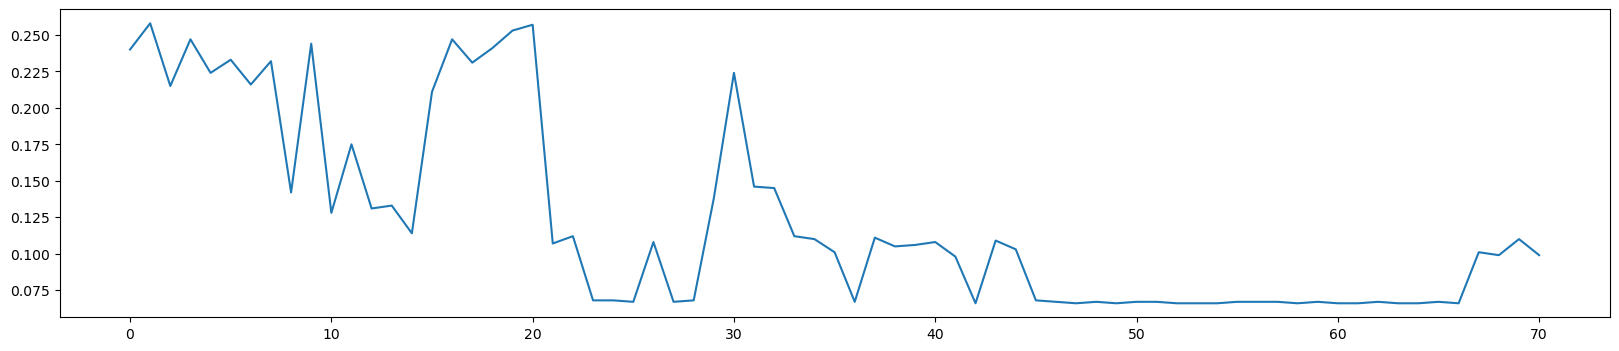

,Path,1,2,3,4,5
7,/kaggle/working/002_0.258_0.463_0.2776_model.h5,2.0,0.258,0.463,0.2776,model.h5
38,/kaggle/working/021_0.257_0.401_0.2937_model.h5,21.0,0.257,0.401,0.2937,model.h5
35,/kaggle/working/020_0.253_0.407_0.2859_model.h5,20.0,0.253,0.407,0.2859,model.h5
31,/kaggle/working/004_0.247_0.495_0.2446_model.h5,4.0,0.247,0.495,0.2446,model.h5
20,/kaggle/working/017_0.247_0.398_0.2994_model.h5,17.0,0.247,0.398,0.2994,model.h5
62,/kaggle/working/010_0.244_0.409_0.2700_model.h5,10.0,0.244,0.409,0.2700,model.h5
17,/kaggle/working/019_0.241_0.396_0.2895_model.h5,19.0,0.241,0.396,0.2895,model.h5
16,/kaggle/working/001_0.240_0.439_0.3160_model.h5,1.0,0.240,0.439,0.3160,model.h5
19,/kaggle/working/006_0.233_0.451_0.2348_model.h5,6.0,0.233,0.451,0.2348,model.h5
48,/kaggle/working/008_0.232_0.461_0.2463_model.h5,8.0,0.232,0.461,0.2463,model.h5


In [43]:
'''
Search for saved models in the working directory and sort them

'''

models = []
for fname in os.listdir('/kaggle/working/'):
    if 'model.h5' in fname:
        m = {}
        m['Path'] = '/kaggle/working/' + fname
        for i, elem in enumerate(fname.split('_')): 
            try:
                m[i+1] = float(elem)
            except:
                m[i+1] = elem
        models.append(m)

if len(models): 
    models = pd.DataFrame(models)
    plot(models.sort_values(1)[2].values)
    models = models.sort_values(2, ascending=False)
    display(models.head(50))